In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
import time
import csv
import random
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from PIL import Image

%matplotlib inline
import matplotlib.pyplot as plt

In [4]:
SEED = 1234

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [5]:
!nvidia-smi

Mon Apr 12 10:58:31 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8     9W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Scaling function
Function for rescaling to range [0, 1]. This is needed for displaying images.

In [6]:
def scale_0_1(x):
  return (x+1)/2

## Loading preprocessed tensors
All tensors were scaled in [-1,1].

In [10]:
PATH = '/content/gdrive/MyDrive/VanGoghGAN_Landscapes'


# Train set
corot_originals = torch.load(PATH+'/DatasetStyle/Corot Originals.pt')
corot_sketches = torch.load(PATH+'/DatasetStyle/Corot Sketches.pt')

monet_originals = torch.load(PATH+'/DatasetStyle/Monet Originals.pt')
monet_sketches = torch.load(PATH+'/DatasetStyle/Monet Sketches.pt')

shishkin_originals = torch.load(PATH+'/DatasetStyle/Shishkin Originals.pt')
shishkin_sketches = torch.load(PATH+'/DatasetStyle/Shishkin Sketches.pt')

van_gogh_originals = torch.load(PATH+'/DatasetStyle/Van Gogh Originals.pt')
van_gogh_sketches = torch.load(PATH+'/DatasetStyle/Van Gogh Sketches.pt')


# Test set
realism_originals_test = torch.load(PATH+'/DatasetStyle/Test/Realism Originals.pt')
realism_sketches_test = torch.load(PATH+'/DatasetStyle/Test/Realism Sketches.pt')

van_gogh_originals_test = torch.load(PATH+'/DatasetStyle/Test/Van Gogh Originals.pt')
van_gogh_sketches_test = torch.load(PATH+'/DatasetStyle/Test/Van Gogh Sketches.pt')

## Preparing DataLoaders

In [13]:
BATCH_SIZE = 1 #instance normalization

In [14]:
class PaintingDataset(Dataset):
  def __init__(self, sketches, originals, label):
    super(PaintingDataset, self).__init__()
    self.sketches = sketches
    self.originals = originals
    labels = torch.empty(len(sketches), 1)
    labels[:] = torch.LongTensor([label])
    self.labels = labels

  def __len__(self):
    return len(self.sketches)

  def __getitem__(self, idx):
    return self.sketches[idx], self.originals[idx], self.labels[idx].long()

Train set

In [16]:
# Impressionism
ds_monet = PaintingDataset(monet_sketches, monet_originals, 0)
print('Monet set size: {}'.format(len(ds_monet)))

# Post-Impressionism
ds_van_gogh = PaintingDataset(van_gogh_sketches, van_gogh_originals, 1)
print('Van Gogh set size: {}'.format(len(ds_van_gogh)))

# Realism
ds_corot = PaintingDataset(corot_sketches, corot_originals, 2)
print('Corot set size: {}'.format(len(ds_corot)))
ds_shishkin = PaintingDataset(shishkin_sketches, shishkin_originals, 2)
print('Shishkin set size: {}'.format(len(ds_shishkin)))

# Train set
ds_train = torch.utils.data.ConcatDataset((ds_monet, ds_van_gogh, ds_corot, ds_shishkin))

print('Impressionism set size: {}'.format(len(ds_monet)))
print('Post-Impressionism set size: {}'.format(len(ds_van_gogh)))
print('Realism set size: {}'.format(len(ds_corot) + len(ds_shishkin)))

print('Train set size: {}'.format(len(ds_train)))

train_loader = DataLoader(dataset=ds_train, batch_size=BATCH_SIZE, shuffle=True)

Monet set size: 483
Van Gogh set size: 344
Corot set size: 219
Shishkin set size: 110
Impressionism set size: 483
Post-Impressionism set size: 344
Realism set size: 329
Train set size: 1156


torch.Size([1, 1, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 1])
tensor([1])


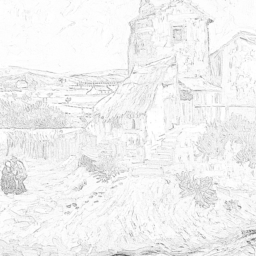

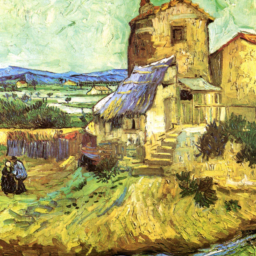

In [17]:
for sketches, originals, labels in train_loader:
  print(sketches.shape)
  print(originals.shape)
  print(labels.shape)
  print(labels[0])
  display(transforms.ToPILImage()(scale_0_1(sketches[0])).convert('RGB'))
  display(transforms.ToPILImage()(scale_0_1(originals[0])).convert('RGB'))
  break

Test set

In [18]:
# Post-Impressionism
ds_postimpressionism_test = PaintingDataset(van_gogh_sketches_test, van_gogh_originals_test, 1)

# Realism
ds_realism_test = PaintingDataset(realism_sketches_test, realism_originals_test, 2)

# Test set
ds_test = torch.utils.data.ConcatDataset((ds_postimpressionism_test, ds_realism_test))

print('Post-Impressionism set size: {}'.format(len(ds_postimpressionism_test)))
print('Realism set size: {}'.format(len(ds_realism_test)))

print('Test set size: {}'.format(len(ds_test)))

test_loader = DataLoader(dataset=ds_test, batch_size=BATCH_SIZE, shuffle=True)

Post-Impressionism set size: 134
Realism set size: 47
Test set size: 181


torch.Size([1, 1, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 1])
tensor([1])


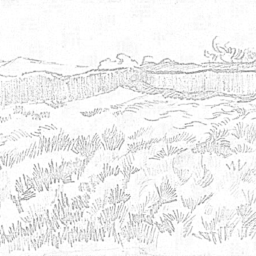

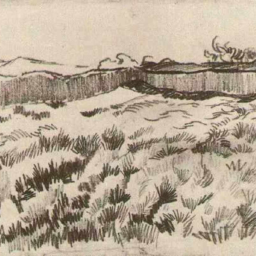

In [22]:
for sketches, originals, labels in test_loader:
  print(sketches.shape)
  print(originals.shape)
  print(labels.shape)
  print(labels[0])
  display(transforms.ToPILImage()(scale_0_1(sketches[0])).convert('RGB'))
  display(transforms.ToPILImage()(scale_0_1(originals[0])).convert('RGB'))
  break

# **Discriminator**

In [23]:
class Discriminator(nn.Module):

    def __init__(self):
        super(Discriminator, self).__init__()

        #C64
        self.c64 = nn.Sequential(
          nn.Conv2d(4,64,(4,4), stride = (2,2), padding = 1),
          nn.LeakyReLU(0.2)
        )

        #C128
        self.c128 = nn.Sequential(
          nn.Conv2d(64,128,(4,4), stride = (2,2), padding = 1),
          nn.BatchNorm2d(128),
          nn.LeakyReLU(0.2)
        )

        #C256
        self.c256 = nn.Sequential(
          nn.Conv2d(128,256,(4,4), stride = (2,2), padding = 1),
          nn.BatchNorm2d(256),
          nn.LeakyReLU(0.2)
        )

        # Padding
        self.pad1 = nn.ZeroPad2d(1)

        #C512
        self.c512 = nn.Sequential(
          nn.Conv2d(256,512,(4,4), stride = (1,1)),
          nn.BatchNorm2d(512),
          nn.LeakyReLU(0.2)
        )

        # Padding
        self.pad2 = nn.ZeroPad2d(1)

        #Patch output
        self.critic = nn.Sequential(
             nn.Conv2d(512,1,(4,4), stride = (1,1))
        )

        #Classification output
        self.classifier = nn.Sequential(
            nn.Conv2d(512,1,(4,4), stride = (1,1)),
            nn.BatchNorm2d(1),
            nn.LeakyReLU(0.2),
            nn.Flatten(),
            nn.Linear(900,3)
        )

        #Weight initialization
        self.weight_init()



    def forward(self, sketch, target):

      #Concatenate images channel wise
      merged =  torch.cat((sketch, target), 1)

      x = self.c64(merged)
      x = self.c128(x)
      x = self.c256(x)
      x = self.pad1(x)
      x = self.c512(x)
      x = self.pad2(x)

      out1 = self.critic(x)
      out2 = self.classifier(x)

      return out1, out2



    def weight_init(self):

      def normal_init(m, mean, std):
        if isinstance(m, (nn.Conv2d)):
          m.weight.data.normal_(mean, std)
          if m.bias.data is not None:
            m.bias.data.zero_()
          print(m, ': Weights initialized')

      for block in self._modules:
        try:
          for m in self._modules[block]:
            normal_init(m, 0.0, 0.02)
        except:
          pass

In [26]:
discriminator = Discriminator()
discriminator.to(device)

Conv2d(4, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1)) : Weights initialized
Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1)) : Weights initialized
Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1)) : Weights initialized
Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1)) : Weights initialized
Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1)) : Weights initialized
Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1)) : Weights initialized


Discriminator(
  (c64): Sequential(
    (0): Conv2d(4, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
  )
  (c128): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
  )
  (c256): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
  )
  (pad1): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
  (c512): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
  )
  (pad2): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
  (critic): Sequential(
    (0): Conv2d(512, 1, kernel_size=(4

In [25]:
# Testing output shapes
#out1, out2 = discriminator(ds_corot[:4][0].to(device), ds_corot[:4][1].to(device))
#print(out1.shape)
#print(out2.shape)

torch.Size([4, 1, 30, 30])
torch.Size([4, 3])


In [ ]:
# Testing CrossEntropyLoss on discriminator output
#input = out2
#target = torch.flatten(ds_corot[:4][2]).to(device)
#print(input.shape)
#print(target.shape)
#loss = nn.CrossEntropyLoss()
#loss(input, target)

torch.Size([4, 3])
torch.Size([4])


tensor(1.3546, device='cuda:0', grad_fn=<NllLossBackward>)

# **Generator**

In [27]:
class Generator(nn.Module):
  def __init__(self, d = 64, n = 3):     #(N,1,256,256)
    super(Generator, self).__init__()
    self.d = d

    #Concatenate Label
    self.embedding = nn.Embedding(n, 100)
    self.linear = nn.Linear(100, d*4*d*4)

    #Unet encoder
    self.conv1 = nn.Conv2d(2, d, 4, 2, 1)
    self.conv2 = nn.Conv2d(d, d*2, 4, 2, 1)
    self.conv2_bn = nn.BatchNorm2d(d*2)
    self.conv3 = nn.Conv2d(d*2, d*4, 4, 2, 1)
    self.conv3_bn = nn.BatchNorm2d(d*4)
    self.conv4 = nn.Conv2d(d*4, d*8, 4, 2, 1)
    self.conv4_bn = nn.BatchNorm2d(d*8)
    self.conv5 = nn.Conv2d(d*8, d*8, 4, 2, 1)
    self.conv5_bn = nn.BatchNorm2d(d*8)
    self.conv6 = nn.Conv2d(d*8, d*8, 4, 2, 1)
    self.conv6_bn = nn.BatchNorm2d(d*8)
    self.conv7 = nn.Conv2d(d*8, d*8, 4, 2, 1)
    self.conv7_bn = nn.BatchNorm2d(d*8)
    self.conv8 = nn.Conv2d(d*8, d*8, 4, 2, 1)


    #Unet decoder
    self.deconv1 = nn.ConvTranspose2d(d*8, d*8, 4, 2, 1)
    self.deconv1_bn = nn.BatchNorm2d(d*8)
    self.deconv2 = nn.ConvTranspose2d(d*8*2, d*8, 4, 2, 1)
    self.deconv2_bn = nn.BatchNorm2d(d*8)
    self.deconv3 = nn.ConvTranspose2d(d*8*2, d*8 , 4, 2, 1)
    self.deconv3_bn = nn.BatchNorm2d(d*8)
    self.deconv4 = nn.ConvTranspose2d(d*8*2, d*8, 4, 2, 1)
    self.deconv4_bn = nn.BatchNorm2d(d*8)
    self.deconv5 = nn.ConvTranspose2d(d*8*2, d*4, 4, 2, 1)
    self.deconv5_bn = nn.BatchNorm2d(d*4)
    self.deconv6 = nn.ConvTranspose2d(d*4*2 , d*2, 4, 2, 1)
    self.deconv6_bn = nn.BatchNorm2d(d*2)
    self.deconv7 = nn.ConvTranspose2d(d*2*2, d, 4, 2, 1)
    self.deconv7_bn = nn.BatchNorm2d(d)
    self.deconv8 = nn.ConvTranspose2d(d*2, 3, 4, 2, 1)

    #Weight initialization
    self.weight_init()



  def forward(self, input, label):
    
    embedding = self.embedding(label)
    linear = self.linear(embedding)

    merged =  torch.cat((input, torch.reshape(linear, (-1, 1, self.d*4, self.d*4))), 1)

    e1 = F.leaky_relu(self.conv1(merged), 0.2)
    e2 = F.leaky_relu(self.conv2_bn(self.conv2(e1)), 0.2)
    e3 = F.leaky_relu(self.conv3_bn(self.conv3(e2)), 0.2)
    e4 = F.leaky_relu(self.conv4_bn(self.conv4(e3)), 0.2)
    e5 = F.leaky_relu(self.conv5_bn(self.conv5(e4)), 0.2)
    e6 = F.leaky_relu(self.conv6_bn(self.conv6(e5)), 0.2)
    e7 = F.leaky_relu(self.conv7_bn(self.conv7(e6)), 0.2)
    e8 = F.relu(self.conv8(e7))
    d1 = F.dropout(self.deconv1_bn(self.deconv1(e8)), 0.5 , training=True)
    d1 = F.relu(torch.cat([d1, e7], 1))
    d2 = F.dropout(self.deconv2_bn(self.deconv2(d1)), 0.5, training=True)
    d2 = F.relu(torch.cat([d2, e6], 1))
    d3 = F.dropout(self.deconv3_bn(self.deconv3(d2)), 0.5 , training=True)
    d3 = F.relu(torch.cat([d3, e5], 1))
    d4 = self.deconv4_bn(self.deconv4(d3))
    d4 = F.relu(torch.cat([d4, e4], 1))
    d5 = self.deconv5_bn(self.deconv5(d4))
    d5 = F.relu(torch.cat([d5, e3], 1))
    d6 = self.deconv6_bn(self.deconv6(d5))
    d6 = F.relu(torch.cat([d6, e2], 1))
    d7 = self.deconv7_bn(self.deconv7(d6))
    d7 = F.relu(torch.cat([d7, e1], 1))
    d8 = self.deconv8(d7)
    output = torch.tanh(d8)

    return output



  def weight_init(self):
    for m in self.modules():
      if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
        m.weight.data.normal_(0.0, 0.02)
        if m.bias.data is not None:
          m.bias.data.zero_()
        print(m, ': Weights initialized')

In [30]:
generator = Generator()
generator.to(device)

Conv2d(2, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1)) : Weights initialized
Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1)) : Weights initialized
Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1)) : Weights initialized
Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1)) : Weights initialized
Conv2d(512, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1)) : Weights initialized
Conv2d(512, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1)) : Weights initialized
Conv2d(512, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1)) : Weights initialized
Conv2d(512, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1)) : Weights initialized
ConvTranspose2d(512, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1)) : Weights initialized
ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1)) : Weights initialized
ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1)) : Weigh

Generator(
  (embedding): Embedding(3, 100)
  (linear): Linear(in_features=100, out_features=65536, bias=True)
  (conv1): Conv2d(2, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv3_bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv4_bn): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(512, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv5_bn): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv6): Conv2d(512, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv6_bn): BatchNorm2d(512, eps=1e-0

In [29]:
#generator(ds_corot[:4][0].to(device), ds_corot[:4][2].to(device)).shape

torch.Size([4, 3, 256, 256])

# Training

In [31]:
# Reload the models from last checkpoint

CHECKPOINTS_FOLDER = PATH+'/StylePix2Pix_Checkpoints'

#epoch = 0
#generator.load_state_dict(torch.load(CHECKPOINTS_FOLDER+'/generator_{}.ckpt'.format(epoch), map_location=torch.device(device)))
#discriminator.load_state_dict(torch.load(CHECKPOINTS_FOLDER+'/discriminator_{}.ckpt'.format(epoch), map_location=torch.device(device)))

In [32]:
# Optimizers and criterions

learnig_rate = 2e-4
generator_optimizer = torch.optim.Adam(generator.parameters(), lr=learnig_rate, betas=(0.5, 0.999))
discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=learnig_rate, betas=(0.5, 0.999))

criterion_L1 = nn.L1Loss().to(device)
criterion_BCE = nn.BCEWithLogitsLoss().to(device)
criterion_CE = nn.CrossEntropyLoss().to(device)

In [33]:
def make_trainable(net, val):
  for param in net.parameters():
    param.requires_grad = val

In [34]:
IMAGES_FOLDER = PATH+'/StylePix2Pix_Images'

def generate_and_save_image(generator, epoch, sketch, label):
  pred = scale_0_1(generator(sketch, label).squeeze())
  image = transforms.ToPILImage()(pred).convert('RGB')
  display(image)
  image.save(IMAGES_FOLDER+'/sketch_epoch_'+str(epoch)+'.jpg')

In [35]:
STATS_FILE = PATH+'/StylePix2Pix_stats.csv'

#with open(STATS_FILE, 'w', newline='') as stats_file:
  #writer = csv.writer(stats_file)
  #writer.writerow(['epoch_number', 'discriminator_loss', 'generator_loss'])

In [36]:
EPOCHS = 50
STATS_FILE = PATH+'/StylePix2Pix_stats.csv'

def train(generator, discriminator, train_loader, test_ds, last_epoch):
  total_step = len(train_loader)
  for epoch in range(last_epoch, last_epoch+EPOCHS):
    # Computing the losses at the end of the epoch
    discriminator_losses = []
    generator_losses = []
    start = time.time()

    for i, (sketch, target, label) in enumerate(train_loader):
      sketch = sketch.detach().to(device)
      target = target.detach().to(device)
      label = label.detach().to(device)
      synthetic_target = generator(sketch, label)

      fake_label = torch.zeros((BATCH_SIZE, 1, 30, 30), device=device).float()
      real_label = torch.ones((BATCH_SIZE, 1, 30, 30), device=device).float()

      # ================================================================== #
      #                      Train the discriminator                       #
      # ================================================================== #

      make_trainable(discriminator, True)
      discriminator_optimizer.zero_grad()

      # Train with fake samples
      out1, out2 = discriminator(sketch, synthetic_target.detach())
      discriminator_loss_fake = criterion_BCE(out1, fake_label)

      # Train with fake samples and real labels
      discriminator_loss_label_fake = criterion_CE(out2, torch.flatten(label))

      # Train with real samples
      out1, out2 = discriminator(sketch, target)
      discriminator_loss_real = criterion_BCE(out1, real_label)

      # Train with real samples and real labels
      discriminator_loss_label_real = criterion_CE(out2, torch.flatten(label))

      # Combined discriminator loss
      discriminator_loss = 0.5*(discriminator_loss_real + discriminator_loss_fake + discriminator_loss_label_real + discriminator_loss_label_fake)
      discriminator_losses.append(discriminator_loss.item())
      discriminator_loss.backward()
      discriminator_optimizer.step()
      
      # ================================================================== #
      #                      Train the generator                           #
      # ================================================================== #

      make_trainable(discriminator, False)
      generator_optimizer.zero_grad()

      # The generator should fool the discriminator
      out1, out2 = discriminator(sketch, synthetic_target)
      adversarial_loss = criterion_BCE(out1, real_label)

      # The generator should produce realistic output
      l1_loss = criterion_L1(synthetic_target, target)

      # The generator should fool the discriminator for labels
      generator_loss_label = criterion_CE(out2, torch.flatten(label))

      generator_loss = adversarial_loss + 100*l1_loss + generator_loss_label
      generator_losses.append(generator_loss.item())
      generator_loss.backward()
      generator_optimizer.step()

      # Check periodically the losses on one batch
      if (i+1) % 500 == 0:
        print('Epoch [{}/{}], Step [{}/{}], Discriminator Loss [{}], Generator Loss [{:.3f}]'.format(epoch+1, last_epoch+EPOCHS, i+1, total_step, discriminator_loss.item(), generator_loss.item()))

    # ================================================================== #
    #                      Validate the generator                        #
    # ================================================================== #
    with torch.no_grad():
      elem = random.randint(0, len(test_ds)-1)
      print('Example of class ' + str(test_ds[elem][2].item()))
      display(transforms.ToPILImage()(scale_0_1(test_ds[elem][1])).convert('RGB'))
      generate_and_save_image(generator, epoch+1, torch.unsqueeze(test_ds[elem][0], 0).to(device), torch.unsqueeze(test_ds[elem][2], 0).to(device))

    discriminator_loss = np.mean(discriminator_losses)
    generator_loss = np.mean(generator_losses)
    print ('Time for epoch {} is {:.2f} sec'.format(epoch + 1, time.time()-start))
    print('Epoch: [{}/{}]...'.format(epoch+1, last_epoch+EPOCHS), 'Discriminator Loss: [{:.3f}]...'.format(discriminator_loss), 'Generator Loss: [{:.3f}]...'.format(generator_loss))
    with open(STATS_FILE, 'a', newline='') as stats_file:
      writer = csv.writer(stats_file)
      writer.writerow([epoch+1, '%.3f'%(discriminator_loss), '%.3f'%(generator_loss)])

    # Save periodically the models
    if (epoch+1) % 5 == 0:
      torch.save(generator.state_dict(), CHECKPOINTS_FOLDER+'/generator_{}.ckpt'.format(epoch+1))
      torch.save(discriminator.state_dict(), CHECKPOINTS_FOLDER+'/discriminator_{}.ckpt'.format(epoch+1))
      print('Epoch: [{}/{}]... Saving models...'.format(epoch+1, last_epoch+EPOCHS))

    print('# ======================================================================================================================= #')

In [37]:
# IMPORTANT >>>>>> Set last_epoch and min_loss of the LAST CHECKPOINT
train(generator, discriminator, train_loader, ds_test, last_epoch=0)

Output hidden; open in https://colab.research.google.com to view.

# Testing the best generator after training

In [38]:
epoch = 50
generator.load_state_dict(torch.load(CHECKPOINTS_FOLDER+'/generator_{}.ckpt'.format(epoch), map_location=torch.device(device)))
discriminator.load_state_dict(torch.load(CHECKPOINTS_FOLDER+'/discriminator_{}.ckpt'.format(epoch), map_location=torch.device(device)))

<All keys matched successfully>

### Example from Train set

404
Example of class 0


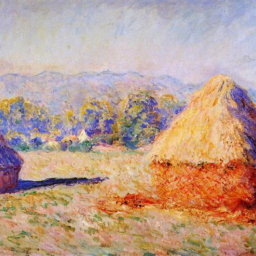

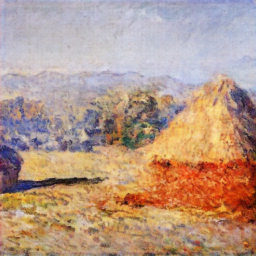

In [39]:
elem = random.randint(0, len(ds_train)-1)
print(elem)
print('Example of class ' + str(ds_train[elem][2].item()))

#display(transforms.ToPILImage()(scale_0_1(ds_train[elem][0])).convert('RGB'))
display(transforms.ToPILImage()(scale_0_1(ds_train[elem][1])).convert('RGB'))

pred = scale_0_1(generator(torch.unsqueeze(ds_train[elem][0], 0).to(device), torch.unsqueeze(ds_train[elem][2], 0).to(device)).squeeze())
display(transforms.ToPILImage()(pred).convert('RGB'))

### Example from Test set

82
Example of class 1


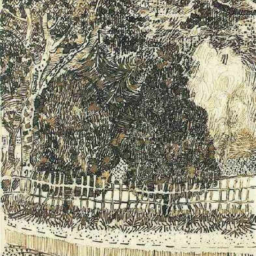

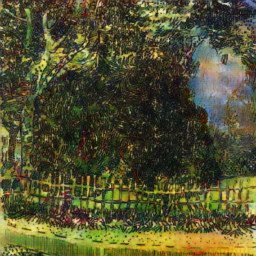

In [46]:
elem = random.randint(0, len(ds_test)-1)
print(elem)
print('Example of class ' + str(ds_test[elem][2].item()))

#display(transforms.ToPILImage()(scale_0_1(ds_test[elem][0])).convert('RGB'))
display(transforms.ToPILImage()(scale_0_1(ds_test[elem][1])).convert('RGB'))

pred = scale_0_1(generator(torch.unsqueeze(ds_test[elem][0], 0).to(device), torch.unsqueeze(ds_test[elem][2], 0).to(device)).squeeze())
display(transforms.ToPILImage()(pred).convert('RGB'))